# Analysing biomarkers to determine the presence of liver cirrhosis.

## ASDS 6302 final project

### Utkarsh Pant

The aim of this project is to develop Logistic Regression and Support Vector Machine models that can predict the presence of liver cirrhosis on the basis of certain biomarkers. **The original research that produced the dataset also sought to investigate the gender-based disparity in the study of the disease, leading to marked difference in patient treatment and outcomes. Hence, the "imbalance" between data available for male and female patients is a key feature of the dataset.**

In [88]:
import pandas
import numpy

import seaborn
import matplotlib.pyplot as plot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [89]:
# Load the dataset and assign column names
liver_data = pandas.read_csv("./dataset/ilpd.csv")
liver_data.columns = ["Age",
                      "Gender",
                      "TB",
                      "DB",
                      "Alkphos",
                      "Sgpt",
                      "Sgot",
                      "TP",
                      "ALB",
                      "AGRatio",
                      "Selector"]
liver_data.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AGRatio,Selector
0,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
1,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
2,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
3,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1
4,46,Male,1.8,0.7,208,19,14,7.6,4.4,1.30,1


## Descriptive statistics and data overview

Checking for any NA or otherwise missing values in the dataset:

In [90]:
liver_data.isna().sum()

Age         0
Gender      0
TB          0
DB          0
Alkphos     0
Sgpt        0
Sgot        0
TP          0
ALB         0
AGRatio     4
Selector    0
dtype: int64

There appear to be no missing values in the dataset, except for the `AGRatio` column. Upon inspection, we see:

In [91]:
liver_data.loc[pandas.isna(liver_data["AGRatio"]), ]

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AGRatio,Selector
208,45,Female,0.9,0.3,189,23,33,6.6,3.9,NaN,1
240,51,Male,0.8,0.2,230,24,46,6.5,3.1,NaN,1
252,35,Female,0.6,0.2,180,12,15,5.2,2.7,NaN,2
311,27,Male,1.3,0.6,106,25,54,8.5,4.8,NaN,2


Since 2 observations are _Male_ and 2 are _Female_ participants, we can safely drop these observations from the dataset for simplicity.

In [92]:
liver_data.dropna(subset=["AGRatio"], inplace=True)

In [93]:
seaborn.set_theme("paper")
seaborn.set_style("whitegrid")

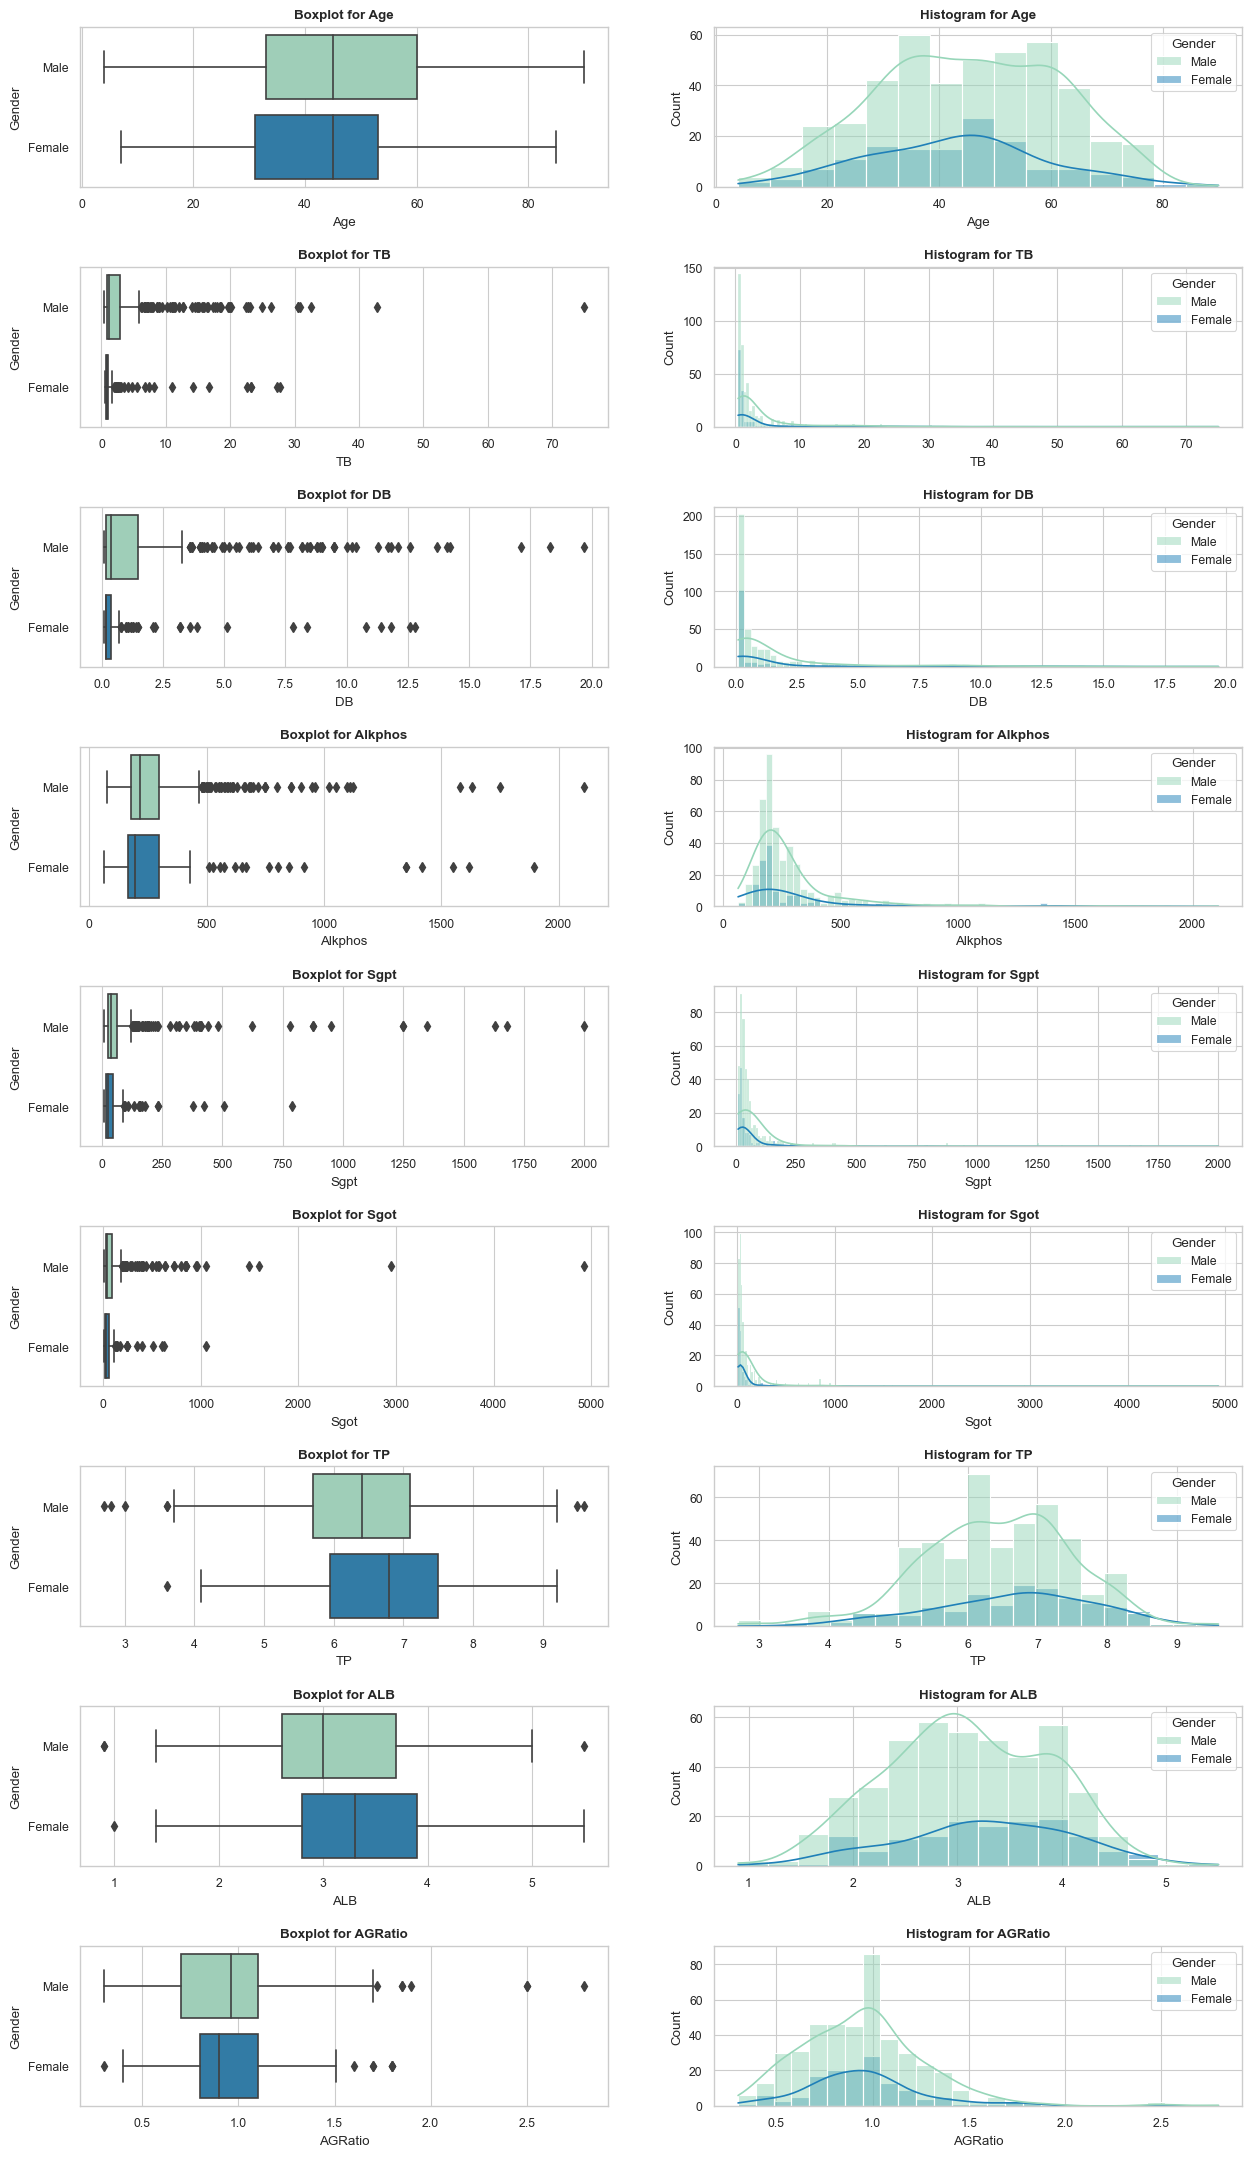

In [94]:
exclude = ["Gender", "Selector"]
continuous = [col for col in liver_data.columns if col not in exclude]

figure, axes = plot.subplots(len(continuous), 2, figsize=(15, 3 * len(continuous)))
axes = axes.flatten()

for i, axes in enumerate(axes):
    # Plot boxplot
    if i % 2 == 0:
        seaborn.boxplot(x=liver_data[continuous[i // 2]], ax=axes, palette = 'YlGnBu', y="Gender", data=liver_data)
        axes.set_title(f'Boxplot for {continuous[i // 2]}', fontdict={'fontweight': 'bold'})
    # # Plot histogram
    else:
        seaborn.histplot(x=liver_data[continuous[i // 2]], ax=axes, kde=True, hue="Gender", palette = 'YlGnBu', data=liver_data)
        axes.set_title(f'Histogram for {continuous[i // 2]}', fontdict={'fontweight': 'bold'})

plot.subplots_adjust(hspace=0.5)  # Adjust the spacing between rows

Text(0.5, 0, 'Gender')

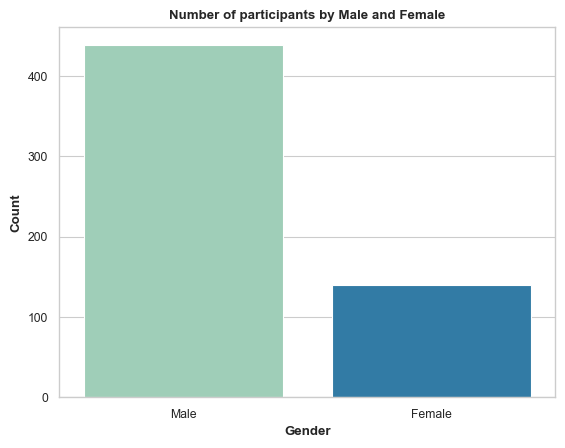

In [96]:
gender_countplot = seaborn.countplot(data = liver_data, x = "Gender", palette = "YlGnBu")
gender_countplot.set_title("Number of participants by Male and Female", fontdict={"fontweight": "bold"})
gender_countplot.set_ylabel("Count", fontdict={"fontweight": "bold"})
gender_countplot.set_xlabel("Gender", fontdict={"fontweight": "bold"})

In [97]:
liver_data.loc[liver_data['Selector'] == 2, 'Selector'] = 0 # healthy
liver_data.loc[liver_data['Selector'] == 1, 'Selector'] = 1

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

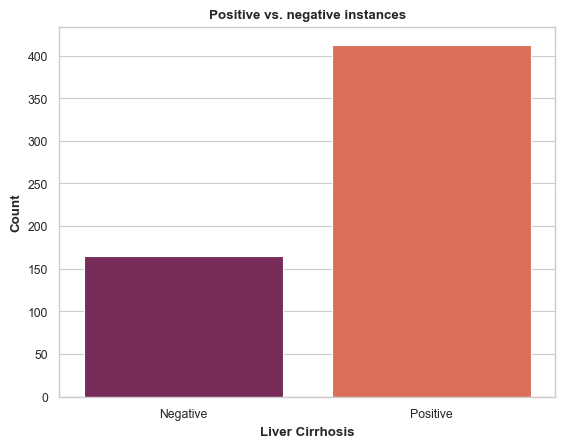

In [98]:
target_countplot = seaborn.countplot(data = liver_data, x = "Selector", palette = "rocket")
target_countplot.set_title("Positive vs. negative instances", fontdict={"fontweight": "bold"})
target_countplot.set_ylabel("Count", fontdict={"fontweight": "bold"})
target_countplot.set_xlabel("Liver Cirrhosis", fontdict={"fontweight": "bold"})
target_countplot.set_xticklabels(["Negative", "Positive"])

In this case, even though _significant_ outliers exist in almost all features, we will not remove them as they are likely to be genuine data points. Imputing or removing outliers tends to "skew" data towards an "average" representation, which may dilute the disparity between sexes that we are trying to capture.

### Data preprocessing

All features are continuous, and have no missing values. Hence, very little pre-processing is required. The only preprocessing needed is the label encoding of the `Gender` feature, which has the labels, "Male" and "Female".

In [99]:
# encode male as 1 and female as 0
liver_data.loc[liver_data["Gender"] == "Male", "Gender"] = 1
liver_data.loc[liver_data["Gender"] == "Female", "Gender"] = 0

In [100]:
# validating our encoding was successful
liver_data["Gender"].value_counts()

Gender
1    439
0    139
Name: count, dtype: int64

We can also impute the outliers in our features, so as to base our modelling and analysis _only_ on the underlying distributions for each continuous variable. Due to the lack of subject-matter expertise and the simple scope, we cannot determine the "true" values of these outliers, and hence we will impute them with the upper and lower "thresholds".

In [101]:
# imputing outliers

for column in continuous:
    Q1 = numpy.quantile(liver_data[column], 0.25)
    Q3 = numpy.quantile(liver_data[column], 0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    liver_data.loc[liver_data[column] < lower_bound, column] = lower_bound
    liver_data.loc[liver_data[column] > upper_bound, column] = upper_bound

### Scaling the data

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
liver_data[continuous] = scaler.fit_transform(liver_data[continuous])

liver_data.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,AGRatio,Selector
0,1.064979,1,2.033636,2.073315,2.098953,0.470077,0.649215,0.950687,0.077750,-0.676143,1
1,1.064979,1,2.033636,2.073315,2.098953,0.350730,0.053822,0.482233,0.203630,-0.171698,1
2,0.818065,1,-0.561691,-0.486781,-0.637668,-1.021760,-0.839267,0.294851,0.329510,0.198229,1
3,1.682266,1,1.188646,1.119554,-0.519130,-0.633882,-0.113632,0.763306,-0.929292,-1.819551,1
4,0.077321,1,-0.078839,-0.185594,-0.400593,-0.872576,-0.950904,1.044378,1.588312,1.207119,1


## Training and testing the models

### Splitting the data into training and testing sets

In [103]:
X = liver_data.drop("Selector", axis = 1)
y = liver_data["Selector"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8093)

### Logistic Regression

In [104]:
logisticRegression = LogisticRegression()
logisticRegression.fit(X_train, y_train)

y_pred_lr = logisticRegression.predict(X_test)

#### Accuracy

In [105]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

0.7011494252873564

The accuracy of the logistic regression model is 70.11%. The confusion matrix is as follows:

#### Confusion matrix

In [106]:
confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
labels = numpy.reshape([f"True Negative: {confusion_matrix_lr[0, 0]}",
                        f"False Positive: {confusion_matrix_lr[0, 1]}",
                        f"False Negative: {confusion_matrix_lr[1, 0]}",
                        f"True Positive: {confusion_matrix_lr[1, 1]}"], (2, 2))

Text(0.5, 1.0, 'Confusion Matrix for Logistic Regression')

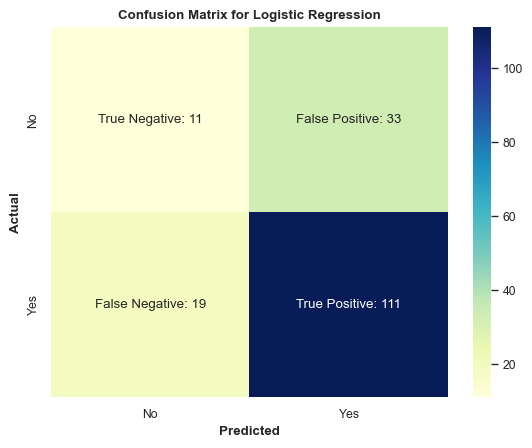

In [107]:
conf_heatmap_lr = seaborn.heatmap(confusion_matrix_lr,
                annot=labels,
                cmap="YlGnBu",
                fmt="",
                xticklabels=["No", "Yes"],
                yticklabels=["No", "Yes"])
conf_heatmap_lr.set_xlabel("Predicted", fontdict={'fontweight': 'bold'})
conf_heatmap_lr.set_ylabel("Actual", fontdict={'fontweight': 'bold'})
conf_heatmap_lr.set_title("Confusion Matrix for Logistic Regression", fontdict={'fontweight': 'bold'})

#### ROC Curve and AuC metric

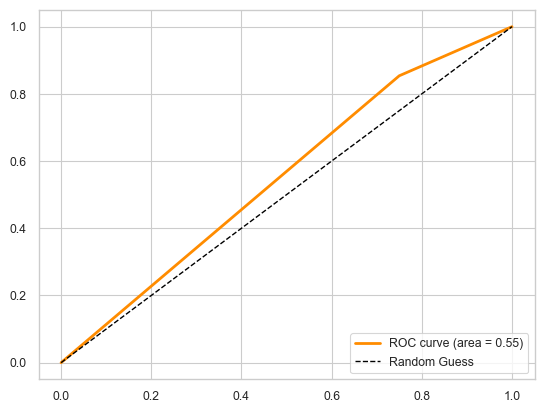

In [108]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_lr)

plot.figure()
plot.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plot.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random Guess')
plot.legend(loc='lower right')
plot.grid(True)
plot.show()

### Support Vector Machine

In [109]:
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

In [110]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_svm

0.7011494252873564

The accuracy of the logistic regression model is 70.11%. The confusion matrix is as follows:

In [111]:
confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)
labels = numpy.reshape([f"True Negative: {confusion_matrix_svm[0, 0]}",
                        f"False Positive: {confusion_matrix_svm[0, 1]}",
                        f"False Negative: {confusion_matrix_svm[1, 0]}",
                        f"True Positive: {confusion_matrix_svm[1, 1]}"], (2, 2))

Text(0.5, 1.0, 'Confusion Matrix for SVM')

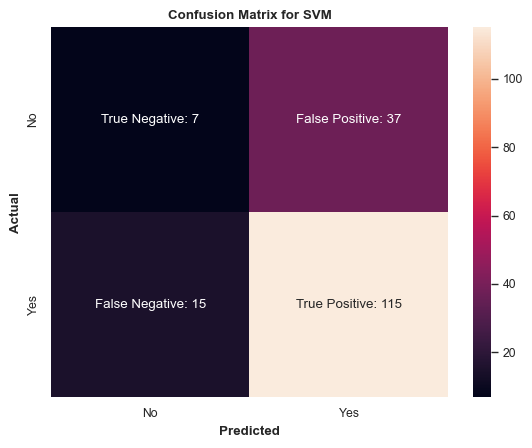

In [112]:
conf_heatmap_svm = seaborn.heatmap(confusion_matrix_svm,
                annot=labels,
                cmap="rocket",
                fmt="",
                xticklabels=["No", "Yes"],
                yticklabels=["No", "Yes"])
conf_heatmap_svm.set_xlabel("Predicted", fontdict={'fontweight': 'bold'})
conf_heatmap_svm.set_ylabel("Actual", fontdict={'fontweight': 'bold'})
conf_heatmap_svm.set_title("Confusion Matrix for SVM", fontdict={'fontweight': 'bold'})

#### ROC Curve and AuC metric

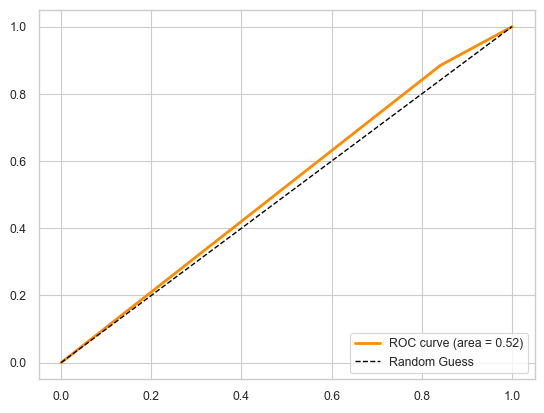

In [113]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)

plot.figure()
plot.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plot.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', label='Random Guess')
plot.legend(loc='lower right')
plot.grid(True)
plot.show()

## Conclusion

As we can see from the above modelling, in its current form, the ILP Dataset results in models that are _average_ in accuracy. The data appears to be linearly separable, due to which Logistic Regression and SVM (linear kernel) models result in the same accuracy. **It is noteworthy that the AUC for the SVM model is _slightly worse_ at 0.52!**

This indicates that unintentional class-imablance in clinical data collection - such as in this dataset - might often result in biased or inconclusive evidence for treatments and patient outcomes. To combat this, we can employ techniques like SMOTE to oversample the minority class (_Female_ participants), which might lead to improvements in model performance.

## References

1. Ramana,Bendi and Venkateswarlu,N.. (2012). ILPD (Indian Liver Patient Dataset). UCI Machine Learning Repository. https://doi.org/10.24432/C5D02C.

2. Straw, I., & Wu, H. (2022). Investigating for bias in healthcare algorithms: a sex-stratified analysis of supervised machine learning models in liver disease prediction. BMJ Health & Care Informatics, 29.

Additionally, supplementary material from [2] was used to determine the correct class labels